In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import math
import scipy


In [2]:
def normalize(matrix):
    normalizedData = (matrix-np.min(matrix))/(np.max(matrix)-np.min(matrix))
    return normalizedData

In [3]:
#Load images

snrImg = []
snrReconstruct = []

rootNoisy = "gr5/Noisy"
noisyImgs = glob.glob(f"{rootNoisy}/*.bmp") + glob.glob(f"{rootNoisy}/*.jpg") 

rootOriginal = "gr5/Original"
originalImgs = glob.glob(f"{rootOriginal}/*.bmp") + glob.glob(f"{rootOriginal}/*.jpg")

originalImgs.sort()
noisyImgs.sort()

In [ ]:
for i in range(len(originalImgs)):
    imgOriginal = cv2.imread(originalImgs[i],0)
    imgNoisy = cv2.imread(noisyImgs[i],0)

    histOrig, bins = np.histogram(imgOriginal.ravel(), bins=256, range=(0, 255))
    histNoise, bins = np.histogram(imgNoisy.ravel(), bins=256, range=(0, 255))

    histNoiseOnly = histNoise - histOrig

    imgNoiseOnly = imgNoisy - imgOriginal


    mean_sq_err = np.mean(imgNoiseOnly**2)
    snr = 10 * np.log10(np.mean(imgOriginal**2) / mean_sq_err)

    variance = np.var(imgNoiseOnly)
    noiseType = ""
    print(variance)
    if variance < 12000:
        noiseType = 'Il rumore è di tipo\n uniforme'
    elif variance >= 12000 and variance < 15000:
        noiseType ='Il rumore è di tipo\n gaussiano'
    elif variance >= 15000:
        noiseType ='Il rumore è di tipo\n impulsivo (sale e pepe)'

    print(snr)
    snrImg.append(snr)
    
    fig, axes = plt.subplots(3,2,figsize=(6,6))
    fig.tight_layout()
    axes[0][0].imshow(imgOriginal, cmap="gray")
    axes[0][0].set_title(f"Immagine originale")

    axes[0][1].hist(imgOriginal.ravel(),256,[0,256])
    axes[0][1].set_title(f"Istogramma immagine originale")

    axes[1][0].imshow(imgNoisy, cmap="gray")
    axes[1][0].set_title(f"Immagine rumorosa")

    axes[1][1].hist(imgNoisy.ravel(),256,[0,256])
    axes[1][1].set_title(f"Istogramma immagine rumorosa")

    axes[2][0].text(0, 0.2, noiseType)
    axes[2][0].set_title(f"Tipo rumore")

    axes[2][1].hist(histNoiseOnly,256,[0,256])
    axes[2][1].set_title(f"Istogramma differenza ")

    plt.show()


In [ ]:
#presa un immagine definisco i tipi di rumore

img = cv2.imread(originalImgs[1],0)
#np.random.seed(42)

#Rumore gaussiano
noise = np.random.normal(size=img.shape)
imgNoisyGauss = img + noise
imgNoisyGauss = cv2.normalize(imgNoisyGauss, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

histOrig, bins = np.histogram(imgOriginal.ravel(), bins=256, range=(0, 255))

histNoise, bins = np.histogram(imgNoisyGauss.ravel(), bins=256, range=(0, 255))

histNoiseOnlyGauss = histNoise - histOrig

#Rumore uniforme
low = 0
high = 255
noise = np.random.uniform(low, high, img.shape)
#noise = np.random.rand(*img.shape) * 255
imgNoisyUni = img + noise
imgNoisyUni = cv2.normalize(imgNoisyUni, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

histNoise, bins = np.histogram(imgNoisyUni.ravel(), bins=256, range=(0, 255))

histNoiseOnlyUnif = histNoise - histOrig

#Rumore sale e pepe
x,y = img.shape
noise = np.random.rand(x,y)*255
salt = noise > 240
pepper = noise < 15
imgNoisySandP = img.copy()
imgNoisySandP[salt] = 255
imgNoisySandP[pepper] = 0
imgNoisySandP = cv2.normalize(imgNoisySandP, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

histNoise, bins = np.histogram(imgNoisySandP.ravel(), bins=256, range=(0, 255))

histNoiseOnlySandP = histNoise - histOrig

#matplot delle immagini con istogrammi
fig, axes = plt.subplots(4,2,figsize=(7,7))
fig.tight_layout()
axes[0][0].imshow(img, cmap="gray")
axes[0][0].set_title(f"Immagine originale")

axes[0][1].hist(imgOriginal.ravel(),256,[0,256])
axes[0][1].set_title(f"Istogramma immagine originale")

axes[1][0].imshow(imgNoisyGauss, cmap="gray")
axes[1][0].set_title(f"Immagine rumorosa gauss")

axes[1][1].hist(histNoiseOnlyGauss,256,[0,256])
axes[1][1].set_title(f"Istogramma rumore gauss")

axes[2][0].imshow(imgNoisyUni, cmap="gray")
axes[2][0].set_title(f"Immagine rumorosa uniforme ")

axes[2][1].hist(histNoiseOnlyUnif,256,[0,256])
axes[2][1].set_title(f"Istogramma rumore uniforme ")

axes[3][0].imshow(imgNoisySandP, cmap="gray")
axes[3][0].set_title(f"Immagine rumorosa sale e pepe ")

axes[3][1].hist(histNoiseOnlySandP,256,[0,256])
axes[3][1].set_title(f"Istogramma rumore sale e pepe ")

plt.show()

In [38]:
 
def euclidean_distance(x1, x2):
    return math.sqrt((x1 - x2) ** 2)


def denoiseImage(X, iter=10, beta=0.5):
  ''' 
  input: X np array for an image, iter int for number of iteration, beta weight

  output: denoised imaged
  '''
  m, n = np.shape(X)
  Y = np.copy(X).astype(dtype=float)
  Ep = np.zeros((m, n))
  for i in range(1,m-1):
      for j in range (1,n-1):
        print(f'Percentage done: {round(((100*i*j)/m*n),2)}                ', end="\r")
        Ep[i][j] = float(((Y[i-1][j] - Y[i][j]) ** 2 + (Y[i][j-1] - Y[i][j]) ** 2 + (Y[i+1][j] - Y[i][j]) ** 2 + (Y[i][j+1] - Y[i][j]) ** 2)) * beta
  print("Matrice dei valori di Ep fatta")
  tot= m*n*iter
  for iteration in range(iter):
    for i in range(1,m-1):
      for j in range (1,n-1):
        print(f'Percentage done: {round(((100*iteration*i*j)/tot),2)}                ', end="\r")

        Ed = float( (X[i][j] - Y[i][j]) ** 2 )
        EpEd = Ep[i][j] + Ed


        high = 255
        low = 0
        while low <= high:
          mid = (high + low) // 2
          Epl = ((Y[i-1][j] - mid) ** 2 + (Y[i][j-1] - mid) ** 2 + (Y[i+1][j] - mid) ** 2 + (Y[i][j+1] - mid) ** 2) * beta
          Edl = float( (X[i][j] - mid) ** 2 )
          energy = Epl + Edl
        
          if energy < EpEd:
              Y[i][j] = mid
              EpEd = energy
          if Epl < Ep[i][j]:
            high = mid - 1
          else:
            low = mid + 1
        
  return Y.astype(dtype=int)


Matrice dei valori di Ep fatta


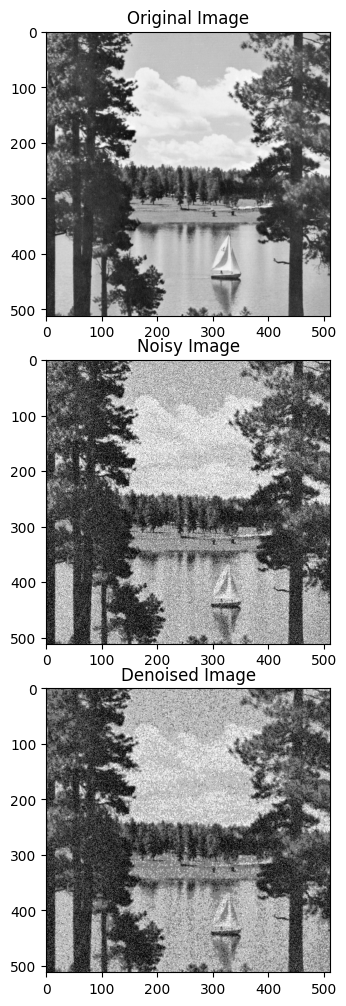

In [37]:
#for i in range(len(originalImgs)):
imgOriginal = cv2.imread(originalImgs[0],0)
imgNoisy = cv2.imread(noisyImgs[0],0)
imgReconstructed = denoiseImage(imgNoisy, iter = 5)
fig, axes = plt.subplots(3,1,figsize=(10,10))
fig.tight_layout()
axes[0].imshow(imgOriginal,cmap="gray")
axes[0].set_title('Original Image')
axes[1].imshow(imgNoisy,cmap="gray")
axes[1].set_title('Noisy Image')
axes[2].imshow(imgReconstructed, cmap="gray")
axes[2].set_title('Denoised Image')
plt.show()

        

In [ ]:
#import pickle
#with open('imgReconstructed.pkl', 'wb') as pickle_file:
#    pickle.dump(imgReconstructed, pickle_file)

#with open('imgReconstructedManual.pkl', 'wb') as pickle_file:
#    pickle.dump(imgReconstructedManual, pickle_file)

In [ ]:
#import os
#os.system("shutdown /s")

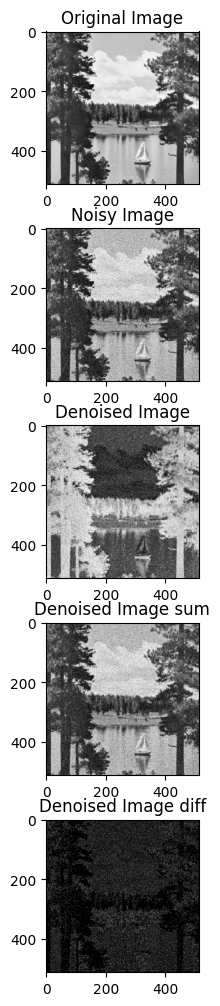

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [39]:
#imgOriginal = cv2.imread(originalImgs[1],0)
#imgNoisy = cv2.imread(noisyImgs[1],0)
#imgReconstructed = denoise_image_icm_bmrf(imgNoisy)
fig, axes = plt.subplots(5,1,figsize=(10,10))
fig.tight_layout()
axes[0].imshow(imgOriginal,cmap="gray")
axes[0].set_title('Original Image')
axes[1].imshow(imgNoisy,cmap="gray")
axes[1].set_title('Noisy Image')
axes[2].imshow((-imgReconstructed), cmap="gray")
axes[2].set_title('Denoised Image')
axes[3].imshow((imgNoisy+imgReconstructed), cmap="gray")
axes[3].set_title('Denoised Image sum')
axes[4].imshow(abs(imgNoisy-imgReconstructed), cmap="gray")
axes[4].set_title('Denoised Image diff')
plt.show()
a =abs(imgNoisy-imgReconstructed)
for i in a:
    print(i)